# Google DR Search

## Importing packages

In [27]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import tqdm
import csv
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

## Generate search terms

Search terms follow the following format: We search for the month and year in the format DR articles inclue a timestap. Manual Google searches proved to provide relevant research results mostly limited to the month provided. In this way we create a list of links to DR articles. All articles are located on the site https://www.dr.dk/nyheder or a subsite. This can be included in the google search. An example of a search is: jan. 2012" AND "sygeplejersker*" site:https://www.dr.dk/nyheder.

In [2]:
# Generate empty list with search terms
search_terms = []
# Generate combinations of year-month and term search combinations
for year in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sep.', 'okt.', 'nov.', 'dec.']
    for month in months:
        term = f'"{month} {year}" AND "sygeplejersker*" site:https://www.dr.dk/nyheder/ \n'
        search_terms.append(term)
# Create final list of search terms, future month-year combinations deleted
search_terms = search_terms[:-4]


We create a total of 124 search terms, for all month-year combinations between January 2012 and August 2022.

## Scraping Google search to retrieve list of links to DR articles
With the following code we scrape Google searches to retrieve a list of links to DR articles, given the DR website does not provide a useful search function. We use Selenium to go execute a Google search and retrieve DR article links. We execute the search, save the HTML for the first results page and then go to further pages of the search results to retrieve more search resutls. Google intervenes when scaping search results too fast. We therefore integrate a break when moving between pages. The break time takes random values between 0.25 and 3.5 seconds.

### Scraping the first three search pages

In [29]:
html_list = []
finished_searches = 0
for i in tqdm.tqdm(search_terms[100:124]):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(i)
    # Get HTML for first search result page
    html = driver.page_source
    html_list.append(html)
    # Go to next result page
    next_page = driver.find_element(By.CSS_SELECTOR, ".NVbCr+ span") #CSS selector only last not previous page
    next_page.click()
    # Define an error used when reaching last search page:
        # When error = 0, there is another resut page.
        # When error = 1, there is no further page on Google, loop stops.
    error = 0
    page = 1
    for page in range(0,1): #Iterates over 3 Pages in total
        try:
            html2 = driver.page_source
            html_list.append(html2)
            # Google detects suspicious behavior and asks to solve some puzzle after 7 iterations. Trying random sleep time and scrolling down to element.
            time.sleep(np.random.uniform(10, 15))
            # Go to next result page
            next_page = driver.find_element(By.CSS_SELECTOR, "#pnnext .NVbCr+ span") #CSS selector only last not previous page
            next_page.click()
            page += 1
        except:
            error += 1
    finished_searches += 1
    time.sleep(np.random.uniform(5,10))
    driver.quit()

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]C:\Users\jgb569\AppData\Local\Temp/ipykernel_24636/3617242327.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [13:13<00:00, 33.05s/it]


### Create link list

In [30]:
# Preparing two empty lists
link_list = []
link_list_clean = []
# Iterating over the results from scraping
for l in html_list:
    soup = BeautifulSoup(l, 'lxml')
    try: 
        links = soup.find('div', class_ = 'v7W49e').find_all('a', href=True)
    except:
        pass
    # Generate list with all links
    for i in links:
        temp = i['href']
        link_list.append(temp)
    # Getting rid of noise, links not pointing to DR but Google infrastructure
    for link in link_list:
        if "webcache.googleusercontent" not in link:
            link_list_clean.append(link)

#### From list to DataFrame

In [31]:
# Creating a pd.DataFrame from link_list_clean
dr_links = pd.DataFrame({'links':link_list_clean})
# For some reason, there are many duplicates included, drop them
dr_links = dr_links.drop_duplicates(subset = 'links')

#### Save dataset

In [32]:
dr_links.to_csv("dr_links_100_124.csv")

# Playground

## Search results statistics

### Scraping Google results

In [50]:
num_search_results = []

for search_term in tqdm.tqdm(search_terms[124:129]):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    # Go to google
    driver.get('https:google.com')
    # Discard cookie message, reject cookies
    cookie = driver.find_element(By.ID, "W0wltc")
    cookie.click()
    # Search for DR news articles
    gsearch = driver.find_element(By.CSS_SELECTOR, "input[title='Søg']")
    gsearch.send_keys(search_term)
    # Get HTML for first search result page
    num_results = driver.find_element(By.ID, "result-stats")
    num_search_results.append(num_results.text)
    time.sleep(np.random.uniform(0.25,1))
    driver.quit()

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]
[WDM] - Downloading:   0%|                                                                 | 0.00/6.21M [00:00<?, ?B/s]
[WDM] - Downloading:   7%|███▋                                                     | 416k/6.21M [00:00<00:01, 4.12MB/s]
[WDM] - Downloading:  28%|███████████████▋                                        | 1.74M/6.21M [00:00<00:00, 9.75MB/s]
[WDM] - Downloading: 100%|████████████████████████████████████████████████████████| 6.21M/6.21M [00:00<00:00, 17.1MB/s]
C:\Users\jgb569\AppData\Local\Temp/ipykernel_13496/2393136411.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.86s/it]


### Cleaning data

In [2]:
# Create list of search result counts
num_search_results_clean = []
for result in num_search_results:
    number_only = result[3:10]
    number_only = number_only.strip()
    number_only = re.sub('\D+', '', number_only)
    num_search_results_clean.append(number_only)

NameError: name 'num_search_results' is not defined

In [52]:
# Change to integer
list_search_results = [int(search) for search in num_search_results_clean]

In [53]:
# Creating a pd.DataFrame from search result count
list_search_results_df = pd.DataFrame({'Month': list_search_results}) # 'MONTH' SHOULD BE 'SEARCH_RESULTS'!

In [54]:
# Export 
list_search_results_df.to_csv("list_search_results_124-128.csv")

## Combine datasets

In [46]:
os.listdir()

['.ipynb_checkpoints',
 'dr_content_list.txt',
 'DR_data_retrieval_and_cleaning.ipynb',
 'DR_data_scraping_Google.ipynb',
 'dr_date.txt',
 'dr_h2_list.txt',
 'dr_links_100_124.csv',
 'dr_links_1_26.csv',
 'dr_links_26_50.csv',
 'dr_links_51_75.csv',
 'dr_links_76_100.csv',
 'dr_titles_list.txt',
 'list_search_results_0-50.csv',
 'list_search_results_50-124.csv',
 'Scraping_first_3_searchpages.ipynb']

In [5]:
list_sr_df_50_124 = pd.read_csv("list_search_results_50-124.csv")
list_sr_df_0_50 = pd.read_csv("list_search_results_0-50.csv")
list_sr_df_124_128 = pd.read_csv("list_search_results_124-128.csv")

In [12]:
df_sr_all = pd.concat([list_sr_df_0_50, list_sr_df_50_124, list_sr_df_124_128], 
          ignore_index=True)

In [13]:
# Generate combinations of year-month
month_year = []
for year in range(2012, 2023):
    months = ['jan.', 'feb.', 'mar.', 'apr.', 'maj', 'jun.', 'jul.', 'aug.', 'sep.', 'okt.', 'nov.', 'dec.']
    for month in months:
        time = f'"{month} {year}"'
        month_year.append(time)
# Create final list of search terms, future month-year combinations deleted
month_year = month_year[:-4]

In [17]:
# Delete obsolete index column
df_sr_all.drop("Unnamed: 0", axis = "columns", inplace = True)

# Column name should be different: 'Month' but 'search_results'
df_sr_all = df_sr_all.rename(columns = {"Month" : "search_results"})

,search_results
0,2220
1,1450
2,1360
3,1310
4,1700
...,...
123,1160
124,10600
125,22
126,423


In [18]:
df_sr_all["month"] = month_year

### Create lineplot

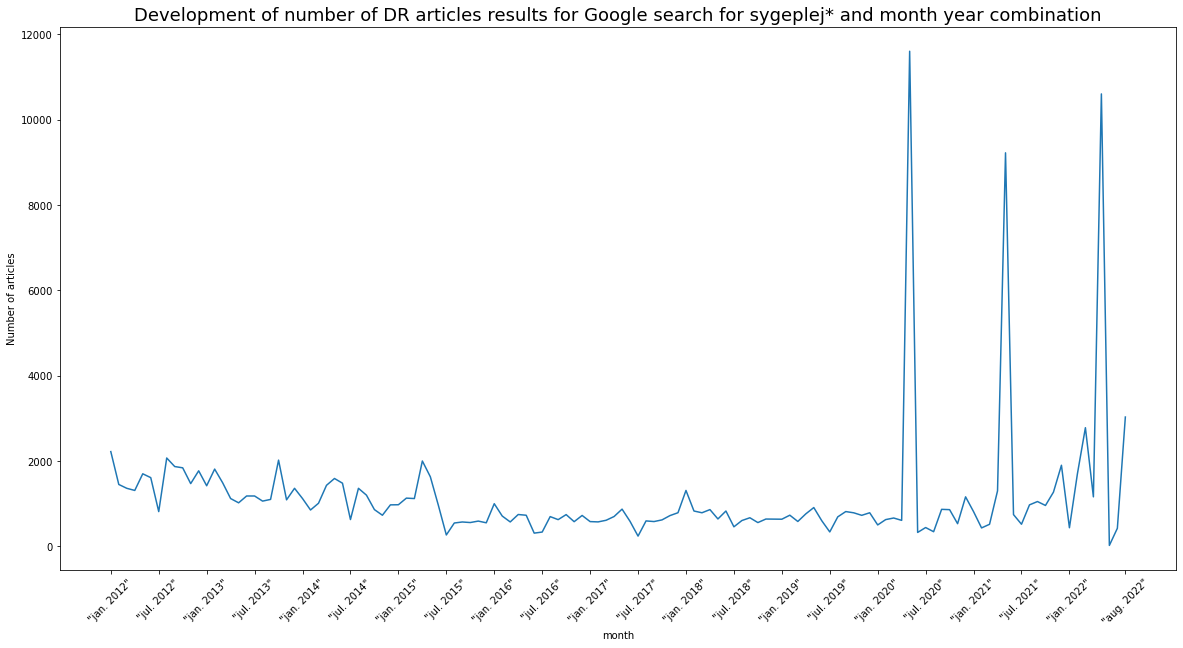

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, figsize=(20,10))

sns.lineplot(x = 'month', y = 'search_results', data = df_sr_all)

_ = plt.title ("Development of number of DR articles results for Google search for sygeplej* and month year combination", fontsize = 18)
_ = plt.ylabel("Number of articles")
_ = plt.xticks([0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 127])
_ = plt.xticks(rotation=45)
plt.show()

In [ ]:
Find months with a lot of results!

In [37]:
df_sr_all_sorted = df_sr_all.sort_values('search_results', ascending = False)
df_sr_all_sorted.head(10)

,search_results,month
100,11600,"""maj 2020"""
124,10600,"""maj 2022"""
112,9220,"""maj 2021"""
127,3030,"""aug. 2022"""
122,2780,"""mar. 2022"""
0,2220,"""jan. 2012"""
7,2070,"""aug. 2012"""
21,2020,"""okt. 2013"""
39,2000,"""apr. 2015"""
119,1900,"""dec. 2021"""


The three most research results are returned for May 2020, 2022, and 2021. It seems that something happens in May in relation to nurses. 